In [1]:
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, pipeline
import matplotlib.pyplot as plt
import torch.optim as optim
from src.data_utils import clean_string, NextTokenDataset, RougeEvaluationDataset
from src.lstm_model import LSTMForNextTokenPrediction
from src.lstm_train import train_model_simple, plot_training_history
from src.eval_transformer_pipeline import calculate_rouge_transformer
from src.eval_lstm import calculate_rouge_simple
from transformers import PreTrainedTokenizerFast


/home/al_dovgan/yandex_neural/projects/sprint2_hw/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load & preprocess

In [2]:
with open('./data/raw_dataset.csv', 'r', encoding='utf-8') as f:
    data = pd.DataFrame([line.rstrip('\n') for line in f], columns=['text'])

In [3]:
data['text'] = data['text'].apply(clean_string)
data = data.drop_duplicates('text')

# create dataset

In [4]:
val_size, seq_len = 0.2, 7
train_texts, val_texts = train_test_split(data['text'].iloc[:], test_size=val_size, random_state=42)
val_texts, test_texts = train_test_split(val_texts, test_size=0.5, random_state=42)

print(f"Train texts: {len(train_texts)}, Val texts: {len(val_texts)}")


Train texts: 1254601, Val texts: 156825


In [5]:
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="./custom_bpe_tokenizer.json"
)
train_dataset = NextTokenDataset(train_texts, tokenizer, seq_len)
val_dataset = NextTokenDataset(val_texts, tokenizer, seq_len)
rouge_dataset = RougeEvaluationDataset(val_texts[:100], tokenizer)  # Только 100 для оценки

Preprocessing dataset: 100%|██████████| 156825/156825 [00:08<00:00, 17628.18it/s]


In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) #23584
val_loader = DataLoader(val_dataset, batch_size=256) #23584
rouge_loader = DataLoader(rouge_dataset, batch_size=1, shuffle=False)


# lstm train

In [7]:
train_dataset.__vocab_size__()

8000

In [8]:
vocab_size = train_dataset.__vocab_size__()

In [9]:
model = LSTMForNextTokenPrediction(vocab_size,
                                    embedding_dim=64,
                                    hidden_dim=64,
                                    n_layers=1)

trained_model, train_losses, rouge_history, val_losses = train_model_simple(
    model=model,
    train_loader=train_loader,
    rouge_loader=rouge_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    epochs=10,
    learning_rate=0.005
)

/home/al_dovgan/yandex_neural/projects/sprint2_hw/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Using device: cuda


Epoch 1/10 [Train]: 100%|██████████| 504/504 [02:13<00:00,  3.77it/s, Loss=5.8992]



Epoch 1 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by of our phone are having a good week so badly and i will be there so
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up and my first time are you feel sorry for a show in the
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later for her back my birt

Epoch 2/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.70it/s, Loss=5.7397]



Epoch 2 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by an hour or something about it this morning last night i did have to keep on
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up im tired but i must do so many more people just made it
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later not feeling

Epoch 3/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.69it/s, Loss=5.6340]



Epoch 3 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by a little bit of the time in the middle of my phone and the best friends
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up my first person i cant go to bed now in your day of
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later and you have to be 

Epoch 4/10 [Train]: 100%|██████████| 504/504 [02:19<00:00,  3.62it/s, Loss=5.5992]



Epoch 4 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by me at the park and i feel like the first time on the way well let
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up the sun bathing suit to make me i think i cant complain it
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later and i cant get an 

Epoch 5/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.70it/s, Loss=5.5281]



Epoch 5 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by myself and in my house and i still have a great time of them on my
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up it is a huge fan of things at my birthday party at this
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later with a great time in

Epoch 6/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.69it/s, Loss=5.5953]



Epoch 6 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by your first day in july again next 2 weeks off to bed on their final test
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up with my mom and he was in the middle of the summer ie
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later i miss it and im

Epoch 7/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.69it/s, Loss=5.4950]



Epoch 7 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by so i am going to the gym at the lake with the good weather i am
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up on sunday amp then a lot of the best friends that u should
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later this weekend to my f

Epoch 8/10 [Train]: 100%|██████████| 504/504 [02:13<00:00,  3.78it/s, Loss=5.5794]



Epoch 8 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by one of our beloved brothers concert tonight now im not talking about it the big city
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up a new iphone before that a bit busy tomorrow i cant afford to
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya la

Epoch 9/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.70it/s, Loss=5.5202]



Epoch 9 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by tomorrow x x for my dad lol and i cant go to the beach in the
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up in an hour amp ill try to come back to work amp i
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later i hope its not in bed i didnt g

Epoch 10/10 [Train]: 100%|██████████| 504/504 [02:16<00:00,  3.68it/s, Loss=5.4559]



Epoch 10 - Оценка ROUGE...

ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by then not to go to work on our bus i miss this morning i miss my
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up and i am on my head hurts so much better than my last
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later though just a tad good t

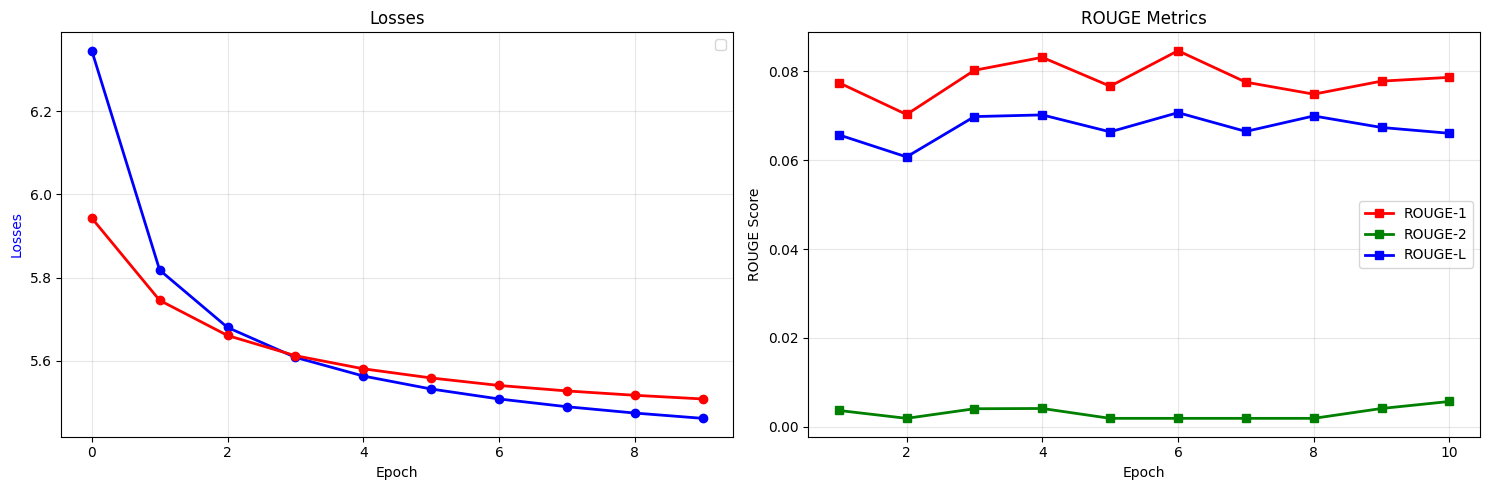

In [15]:
plot_training_history(train_losses, rouge_history, val_losses)

# transformer

In [12]:
generator = pipeline(
    "text-generation", 
    model="distilgpt2",
    device=-1  # Используем CPU
)
result = generator("Раз, два, три, четыре, пять, ", max_length=20, do_sample=True, top_k=50)
print(result[0]["generated_text"])

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Раз, два, три, четыре, пять, лька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, челька и три, чел


# evals

TRANSFORMER

In [13]:
calculate_rouge_transformer(generator=generator, rouge_loader=rouge_loader)


ПРИМЕРЫ АВТОДОПОЛНЕНИЙ (distilgpt2):

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: me.
So this is the
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: some oo oo I'll have to wait
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: im gonna have to go back to sleep for an
Цель (1/4 текста): nu kes moo ches and o ll ian hugs


{'rouge1': np.float64(0.030440148087206912),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.031559029206088024),
 'rougeLsum': np.float64(0.030440148087206905)}

LSTM

In [14]:
calculate_rouge_simple(model, rouge_loader, tokenizer, 0)


ПРИМЕРЫ АВТОДОПОЛНЕНИЙ:

--- Пример 1 ---
Вход (3/4 текста): i am a geek im cat alo gu ing my books and scan ning them by...
Сгенерировано: i am a geek im cat alo gu ing my books and scan ning them by the time to play to go to the house i wish it was it in the
Цель (1/4 текста): bar code into the pu ter

--- Пример 2 ---
Вход (3/4 текста): godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up...
Сгенерировано: godd amn that was fun now headin to dom s to bbq and chill out after pick in up some g rub at a amp js up stairs but not for a week when my brother is the best in
Цель (1/4 текста): amp blue la bel gonna be a great day

--- Пример 3 ---
Вход (3/4 текста): mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later...
Сгенерировано: mary nu ke lover i woke up too early im gonna go back to sleep for an hour or two ill talk to ya later i miss them going to go to the house its a good thing

{'rouge1': np.float64(0.07314544605991927),
 'rouge2': np.float64(0.0018604651162790697),
 'rougeL': np.float64(0.06252296638992721),
 'rougeLsum': np.float64(0.062395102450803305)}

# Вывод

Результаты показывают, что для нашей конкретной задачи автодополнения дообученная LSTM-модель демонстрирует более высокие метрики ROUGE по сравнению с недообученной трансформерной моделью distilgpt2. Это подчеркивает важность специализации моделей под конкретную предметную область, даже если используются более простые архитектуры.